In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import network_generation as homomul
import spread_simulation
from tqdm.notebook import tqdm

# Spread based on Consolidation and Homophily

In [15]:
model_settings = {
    'N': 3200, 
    'm': 5, 
    'consolidation_param': 0.1,
    'marginal_distribution': [[0.5,0.5],[0.5,0.5]], 
    'homophily': 0.8, 
    'complex_threshold': 0.16,
    'initial_seed_filter': lambda x: x.nodes
}

experiment_settings = {
    'n_networks': 2,
    'n_initial_seeds': 5
}

def batch_simulate(N: int, m: int, consolidation_param: float, homophily: float,
                       marginal_distribution: list = [[0.5,0.5],[0.5,0.5]], complex_threshold: float = 0.16,
                       initial_seed_filter = lambda x: x.nodes,
                       n_networks: int = 3, n_initial_seeds: int = 10) -> list[float]: 
    
    comp_pop_frac_tnsr = homomul.consol_comp_pop_frac_tnsr(marginal_distribution, consolidation_param)

    h1 = np.array([[homophily, 1-homophily], [1-homophily, homophily]])
    h2 = h1.copy()
    h_mtrx_lst = np.array([h1,h2])

    results = []

    for _ in range(n_networks): 
        g = homomul.am_v2(
                    h_mtrx_lst,
                    comp_pop_frac_tnsr,
                    homophily_kind='all',
                    directed=False,
                    pop_fracs_lst = marginal_distribution,
                    N=N,
                    m=m
                    )
        
        filterd_nodes = initial_seed_filter(g)
        n = min(n_initial_seeds, len(filterd_nodes))   
        initial_seeds = np.random.choice(filterd_nodes, n, replace=False)

        for initial in initial_seeds:         
            initial = [initial] + [x for x in g.neighbors(initial)]
            g = spread_simulation.complex_spread(g, initial, complex_threshold)
            results.append(spread_simulation.fraction_infected(g))

    return np.average(results), np.average([x > 0.9 for x in results])

batch_simulate(**model_settings, **experiment_settings)

(0.008906250000000001, 0.0)

In [4]:
def setting_simulate(v1_key, v1_settings, v2_key, v2_settings, default_model_setting: dict, experiment_settings: dict): 

    results_average = np.zeros((v1_settings.size, v2_settings.size))
    results_global_spread = results_average.copy()

    progress_bar = tqdm(total=v1_settings.size * v2_settings.size)

    for i, v1 in enumerate(v1_settings): 
        for j, v2 in enumerate(v2_settings):

            default_model_setting[v1_key] = v1
            default_model_setting[v2_key] = v2

            r_average, r_global_spread = batch_simulate(**default_model_setting, **experiment_settings)
            tqdm.write(f'{v1_key}: {v1:.2f} / {v2_key}: {v2:0.2f} => average = {r_average:0.2f}; global = {r_global_spread:0.2f}')

            results_average[i, j] = r_average
            results_global_spread[i, j] = r_global_spread

            progress_bar.update()

    progress_bar.close()

    return results_average, results_global_spread


In [5]:
homophily_settings = np.linspace(0,1,11)
consolidation_settings = np.linspace(0,0.5, 6)

results_average, results_global_spread = setting_simulate('consolidation_param', consolidation_settings, 
                                                          'homophily', homophily_settings, 
                                                          model_settings, experiment_settings)


  0%|          | 0/66 [00:00<?, ?it/s]

consolidation_param: 0.00 / homophily: 0.00 => average = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.10 => average = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.20 => average = 0.11; global = 0.10
consolidation_param: 0.00 / homophily: 0.30 => average = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.40 => average = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.50 => average = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.60 => average = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.70 => average = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.80 => average = 0.21; global = 0.20
consolidation_param: 0.00 / homophily: 0.90 => average = 0.40; global = 0.40
consolidation_param: 0.00 / homophily: 1.00 => average = 0.15; global = 0.00
consolidation_param: 0.10 / homophily: 0.00 => average = 0.01; global = 0.00
consolidation_param: 0.10 / homophily: 0.10 => average = 0.21; global = 0.20

**Average Spread**

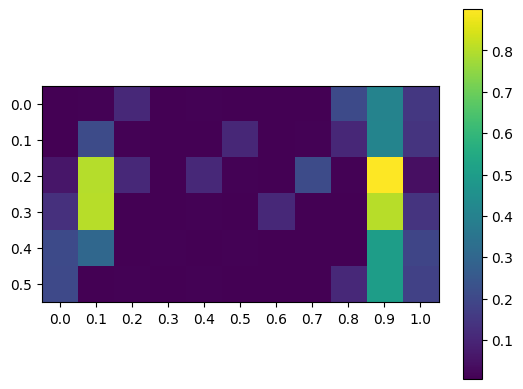

In [10]:
plt.imshow(results_average, interpolation='nearest')
plt.xticks(np.arange(homophily_settings.size), [f'{x:0.1f}' for x in homophily_settings])
plt.yticks(np.arange(consolidation_settings.size), [f'{x:0.1f}' for x in consolidation_settings])
plt.colorbar()
plt.show()

**Proportion of Global Spread**

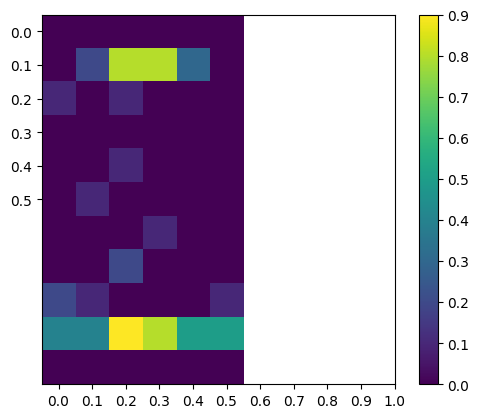

In [7]:
plt.imshow(results_global_spread, interpolation='nearest')
plt.xticks(np.arange(homophily_settings.size), [f'{x:0.1f}' for x in homophily_settings])
plt.yticks(np.arange(consolidation_settings.size), [f'{x:0.1f}' for x in consolidation_settings])
plt.colorbar()
plt.show()

## Groups ability to spread: 


In [ ]:
def filter_by_group(group): 
    def f(g: nx.Graph) -> list:
        return [x for x, attr in g.nodes('attr') if attr == group]
    
    return f
    
model_settings['initial_seed_filter'] = filter_by_group((0,0))
results_average, results_global_spread = setting_simulate('consolidation_param', consolidation_settings, 
                                                          'homophily', homophily_settings, 
                                                          model_settings, experiment_settings)

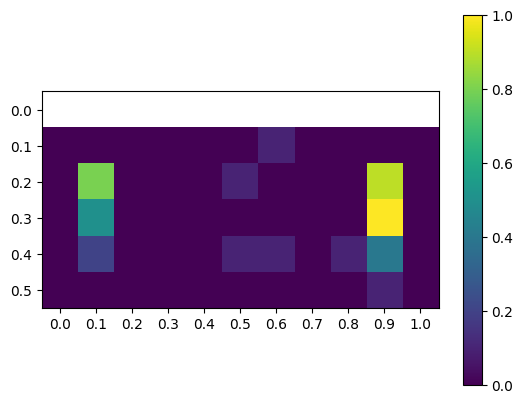

In [17]:
plt.imshow(results_global_spread, interpolation='nearest')
plt.xticks(np.arange(homophily_settings.size), [f'{x:0.1f}' for x in homophily_settings])
plt.yticks(np.arange(consolidation_settings.size), [f'{x:0.1f}' for x in consolidation_settings])
plt.colorbar()
plt.show()

  0%|          | 0/66 [00:00<?, ?it/s]

consolidation_param: 0.00 / homophily: 0.00 => average = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.10 => average = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.20 => average = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.30 => average = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.40 => average = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.50 => average = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.60 => average = 0.01; global = 0.00
consolidation_param: 0.00 / homophily: 0.70 => average = 0.11; global = 0.10
consolidation_param: 0.00 / homophily: 0.80 => average = 0.21; global = 0.20
consolidation_param: 0.00 / homophily: 0.90 => average = 0.30; global = 0.30
consolidation_param: 0.00 / homophily: 1.00 => average = 0.11; global = 0.00
consolidation_param: 0.10 / homophily: 0.00 => average = 0.01; global = 0.00
consolidation_param: 0.10 / homophily: 0.10 => average = 0.01; global = 0.00

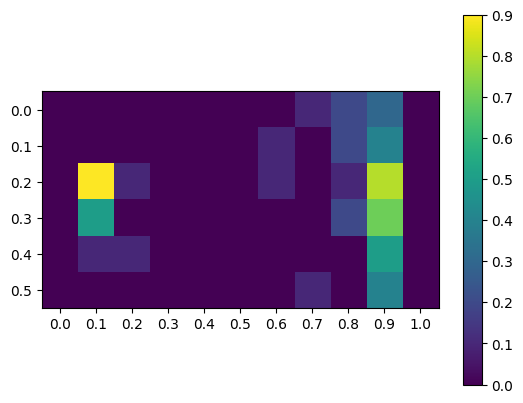

In [18]:
model_settings['initial_seed_filter'] = filter_by_group((0,1))
results_average, results_global_spread = setting_simulate('consolidation_param', consolidation_settings, 
                                                          'homophily', homophily_settings, 
                                                          model_settings, experiment_settings)

plt.imshow(results_global_spread, interpolation='nearest')
plt.xticks(np.arange(homophily_settings.size), [f'{x:0.1f}' for x in homophily_settings])
plt.yticks(np.arange(consolidation_settings.size), [f'{x:0.1f}' for x in consolidation_settings])
plt.colorbar()
plt.show()